In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init
import copy
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
#CONSTANTS

D = 3 # Number of dimensions
Nh = 100 # Hidden dimension
num_samples = 20

l = 5
data_range = (-l, l)

In [ ]:
def kinematics_f(x, psi):
    constant = -1/2
    grad_x_values = torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
    laplacian_values = torch.zeros_like(x)

    # Compute the Laplacian for each dimension separately
    for i in range(x.shape[1]):
        laplacian_dim = torch.autograd.grad(grad_x_values[:, i].sum(), x, create_graph=True)[0]
        laplacian_values[:, i] = laplacian_dim[:, i]
    laplacian_values = torch.sum(laplacian_values, dim=1).view(-1,1)
    return constant * laplacian_values, grad_x_values

def HO_potential(x):
    potential = torch.square(x)/2
    potential_3d = torch.sum(potential, dim=1).view(-1,1)
    return potential_3d

def Nilsson_model(x, device):
    x_freq = 4
    y_freq = 3
    z_freq = 2
    freq_reg = torch.tensor([x_freq, y_freq, z_freq]).to(device)

    potential = freq_reg * torch.square(x)/2
    potential_3d = torch.sum(potential, dim=1).view(-1,1)
    return potential_3d

def HA_potential(x):
    r = torch.sqrt(torch.sum(torch.square(x), dim=1))
    potential_3d = -1 / r
    return potential_3d.view(-1,1)

def woods_potential(x):
    r = torch.sqrt(torch.sum(torch.square(x), dim=1))
    V_0 = 6.5
    a = 0.3
    R = 3
    potential_3d = -V_0 / (1 + torch.exp((r - R) / a))
    return potential_3d.view(-1,1)

In [ ]:
def schrodinger_loss(x, psi, E, data_range, model_list, edge_indices, device):
    M = x.shape[0]
    x_R = data_range[1]
    x_L = data_range[0]
    L_norm = torch.square(torch.sum(torch.square(psi)) * ((x_R - x_L)**x.shape[1])/M - 1)

    psi_eigen = torch.zeros((M, 1)).to(device)
    for i in range(len(model_list)):
        psi_eigen += torch.square(torch.mean(psi * model_list[i](x, device)[0]))
    L_orth = torch.sum(psi_eigen)

    kinematics, grads = kinematics_f(x, psi)
    potential = HO_potential(x)
    H_psi = kinematics + potential * psi
    L_DE = torch.mean(torch.square(H_psi - E * psi))

    L_BC = torch.sum(torch.square(psi[edge_indices]) + torch.square(grads[edge_indices]))

    total_loss = L_DE + L_norm + L_orth + L_BC
    return total_loss, L_DE, L_orth, L_norm, L_BC, torch.sum(psi * H_psi) / torch.sum(psi * psi)

In [ ]:
#MODEL

class NN(nn.Module):
    def __init__(self, D, Nh):
        super(NN, self).__init__()
        self.lambda_layer = nn.Linear(1, 1)
        self.layer1 = nn.Linear(D + 1, Nh)
        self.layer2 = nn.Linear(Nh + 1, Nh)
        self.layer3 = nn.Linear(Nh + 1, Nh)
        self.layer4 = nn.Linear(Nh + 1, 1)

        nn.init.constant_(self.lambda_layer.bias, -1)

        nn.init.uniform_(self.lambda_layer.weight, a=0, b=1)

    def forward(self, x, device):
        I = torch.ones((x.shape[0], 1)).requires_grad_(True).to(device)

        E = self.lambda_layer(I)
        input = torch.cat([x, E], dim = 1)
        h1 = torch.sin(self.layer1(input))
        input_h1 = torch.cat([h1, E], dim = 1)
        h2 = torch.sin(self.layer2(input_h1))
        input_h2 = torch.cat([h2, E], dim = 1)
        h3 = torch.sin(self.layer3(input_h2))
        input_h3 = torch.cat([h3, E], dim = 1)
        pred = self.layer4(input_h3)

        return pred, E

In [ ]:
def train3D(model, optimizer, scheduler, learning_rates, epochs, num_samples, data_range):
    loss_history = []
    E_history = []
    model_list = []
    solutions = 0
    threshold = 2e-5
    convergence = 0
    required_solutions = 1

    data1 = torch.linspace(data_range[0], data_range[1], num_samples)
    data2 = torch.linspace(data_range[0], data_range[1], num_samples)
    data3 = torch.linspace(data_range[0], data_range[1], num_samples)

    X, Y, Z = torch.meshgrid(data1, data2, data3)
    data1 = X.reshape(-1, 1)
    data2 = Y.reshape(-1, 1)
    data3 = Z.reshape(-1, 1)
    data_concat = torch.hstack((data1, data2, data3)).to(device)
    data_concat.requires_grad = True

    edge_indices = torch.any((data_concat == data_range[0]) | (data_concat == data_range[1]), dim=1).nonzero(as_tuple=False).squeeze()
    li = []
    for epoch in range(epochs):
        pred, E = model(data_concat, device)
        loss, L_DE, L_orth, L_norm, L_BC, var_E = schrodinger_loss(data_concat, pred, E, data_range, model_list, edge_indices, device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())
        E_history.append((E.mean().item(), var_E.item()))
        convergence += 1
        if loss < threshold:
            li.append(epoch)
            convergence = 0
            model_list.append(copy.deepcopy(model))
            solutions += 1
            for param_group, (_, lr) in zip(optimizer.param_groups, learning_rates.items()):
                param_group['lr'] = lr

        if solutions == required_solutions:
            break

        if epoch % 1000 == 0:
            psi_3d = model(data_concat, device)[0].cpu().detach().numpy().reshape(num_samples, num_samples, num_samples)
            probability_density_flat = psi_3d.flatten()

            opacity = np.where(np.abs(probability_density_flat) < 0.1, 0.05, 0.8)

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            scatter = ax.scatter(data1, data2, data3, c=probability_density_flat, cmap='viridis', alpha = opacity)
            cbar = fig.colorbar(scatter)
            cbar.set_label('Probability Density')

            plt.show()

            # Projection onto 2D contour plot
            fig2 = plt.figure()
            ax2 = fig2.add_subplot(111)
            contour = ax2.contourf(X[:, :, 0], Y[:, :, 0], psi_3d.sum(axis=2), cmap='viridis')

            plt.show()

            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss}, LDE_Loss: {L_DE.item():.4f}, Orth_Loss: {L_orth.item():.4f}, Norm_Loss: {L_norm.item():.4f}, BC_Loss: {L_BC.item():.4f}, Eigenvalue: {E[0].item():.4f}, Vari_E: {var_E.item():.4f}, Solutions: {solutions}')
    return loss_history, E_history, model_list, model, li

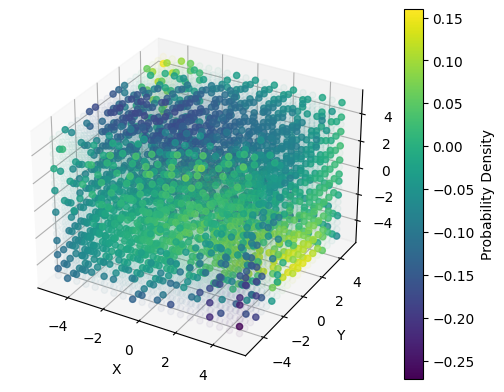

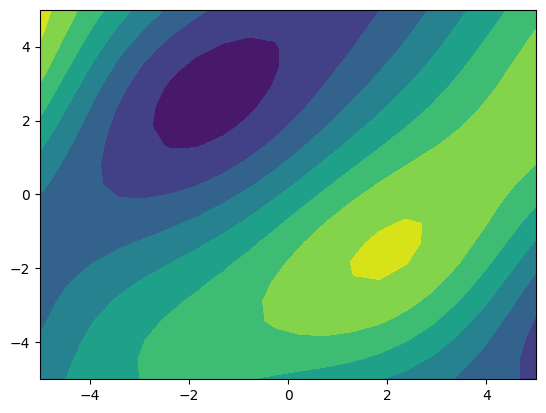

Epoch [1/1000000], Loss: 516.005859375, LDE_Loss: 4.3555, Orth_Loss: 0.0000, Norm_Loss: 395.7319, BC_Loss: 115.9184, Eigenvalue: -0.7297, Vari_E: 12.2689, Solutions: 0


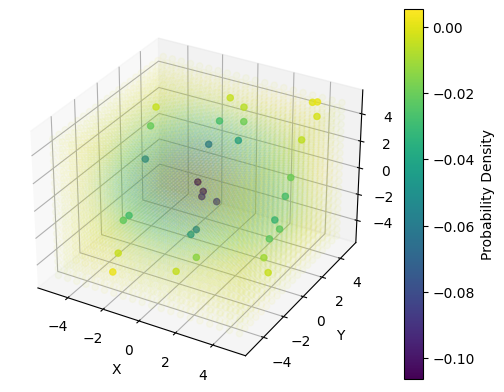

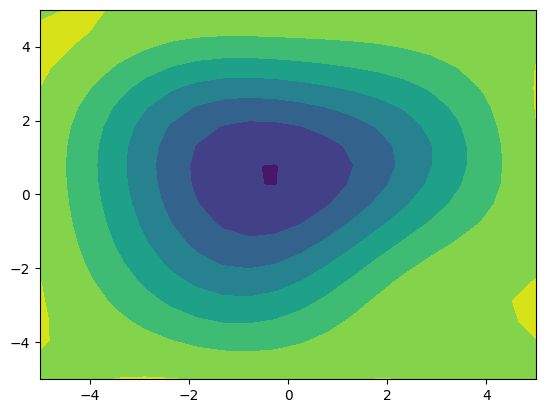

Epoch [1001/1000000], Loss: 0.2623594403266907, LDE_Loss: 0.0222, Orth_Loss: 0.0000, Norm_Loss: 0.0223, BC_Loss: 0.2178, Eigenvalue: 0.4640, Vari_E: 4.5332, Solutions: 0


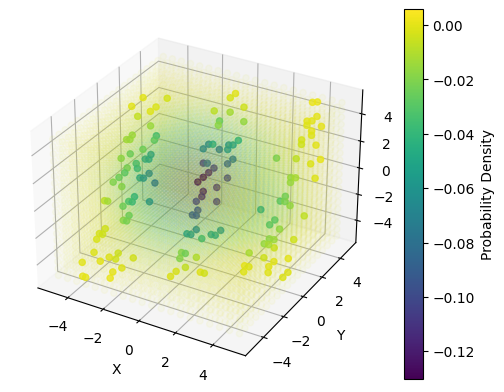

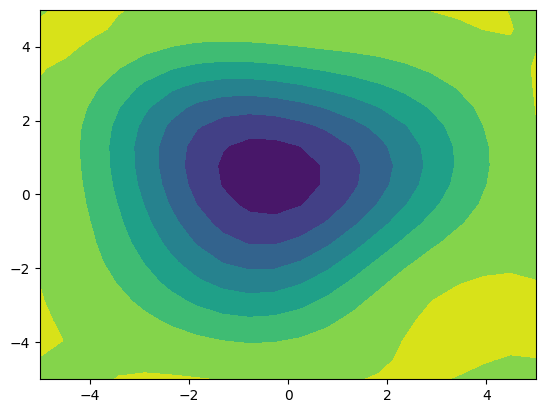

Epoch [2001/1000000], Loss: 0.09005282819271088, LDE_Loss: 0.0152, Orth_Loss: 0.0000, Norm_Loss: 0.0044, BC_Loss: 0.0704, Eigenvalue: 0.7143, Vari_E: 3.8009, Solutions: 0


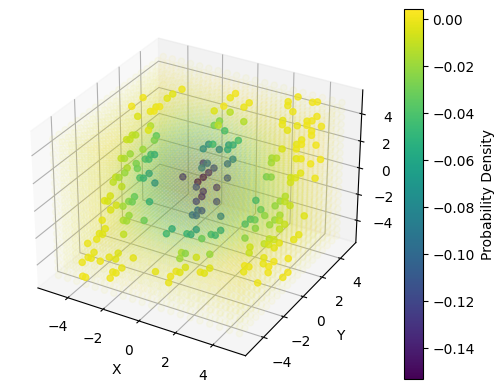

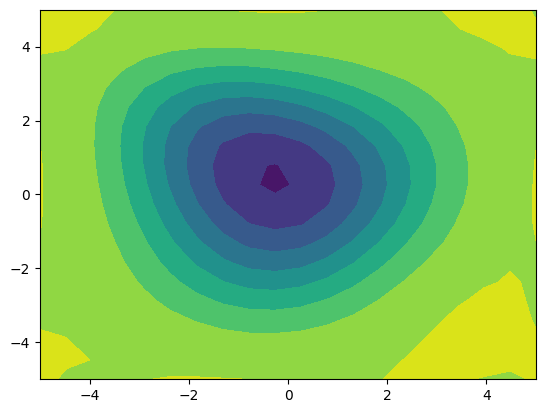

Epoch [3001/1000000], Loss: 0.021600980311632156, LDE_Loss: 0.0101, Orth_Loss: 0.0000, Norm_Loss: 0.0002, BC_Loss: 0.0113, Eigenvalue: 0.9778, Vari_E: 3.2781, Solutions: 0


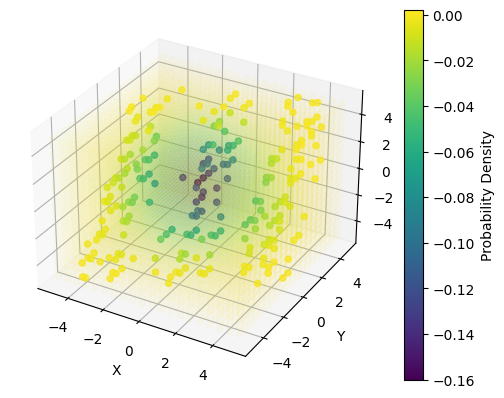

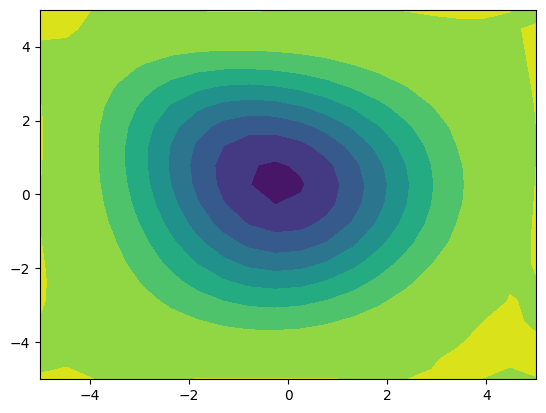

Epoch [4001/1000000], Loss: 0.012109529227018356, LDE_Loss: 0.0083, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0038, Eigenvalue: 1.1434, Vari_E: 3.1218, Solutions: 0


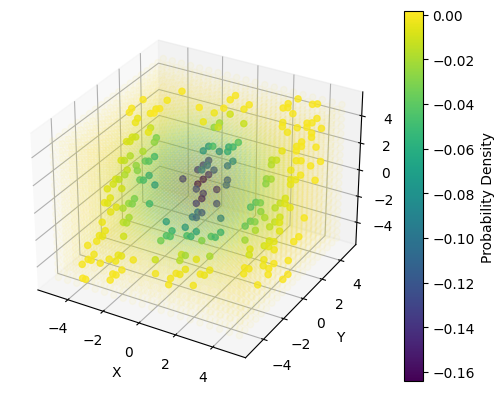

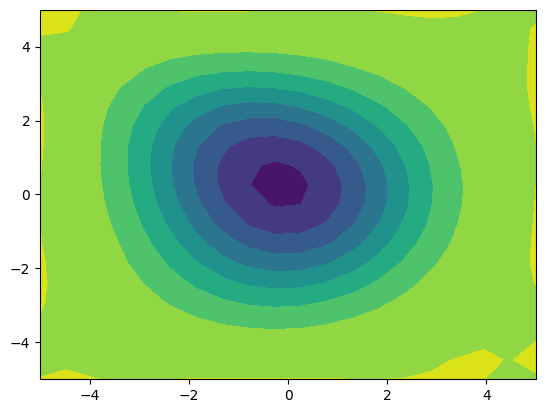

Epoch [5001/1000000], Loss: 0.008994108997285366, LDE_Loss: 0.0069, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0021, Eigenvalue: 1.3324, Vari_E: 3.0226, Solutions: 0


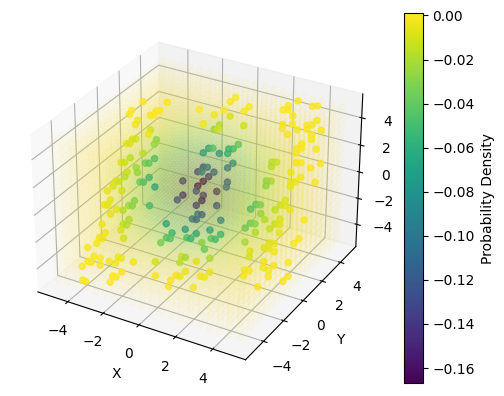

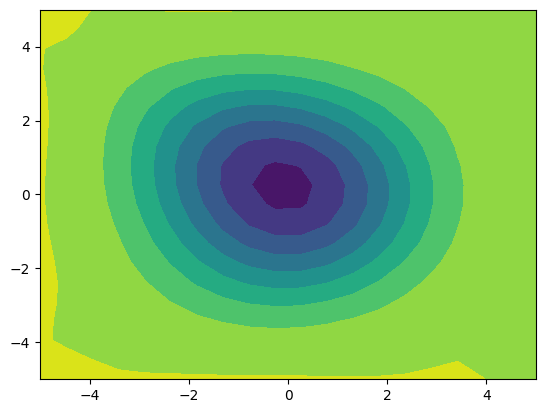

Epoch [6001/1000000], Loss: 0.007481366395950317, LDE_Loss: 0.0059, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0016, Eigenvalue: 1.4947, Vari_E: 2.9450, Solutions: 0


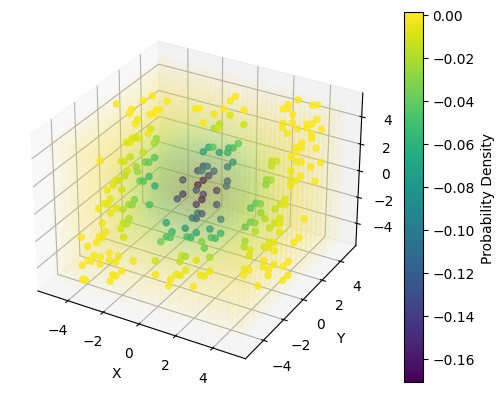

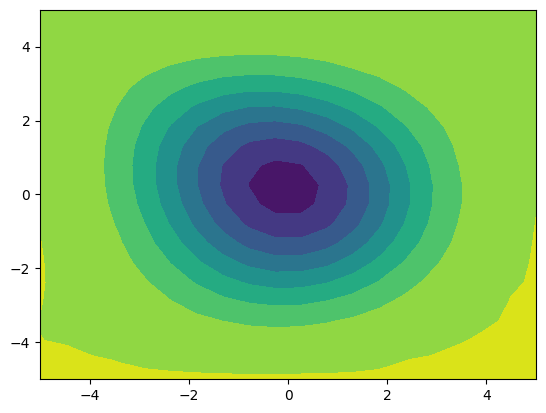

Epoch [7001/1000000], Loss: 0.006948703899979591, LDE_Loss: 0.0050, Orth_Loss: 0.0000, Norm_Loss: 0.0001, BC_Loss: 0.0018, Eigenvalue: 1.5708, Vari_E: 2.8440, Solutions: 0


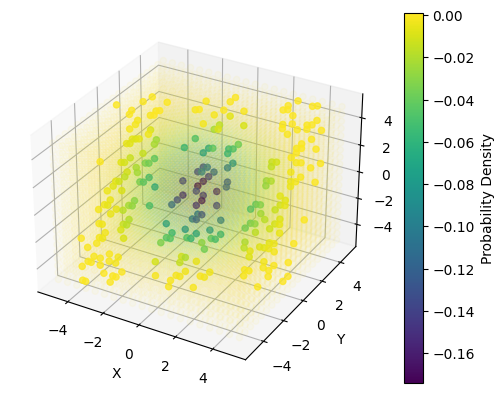

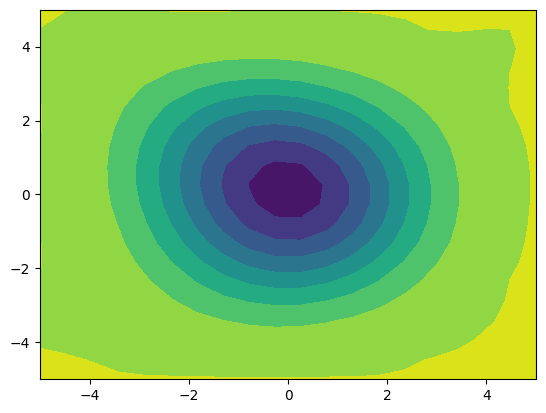

Epoch [8001/1000000], Loss: 0.005180730484426022, LDE_Loss: 0.0044, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0008, Eigenvalue: 1.6654, Vari_E: 2.7657, Solutions: 0


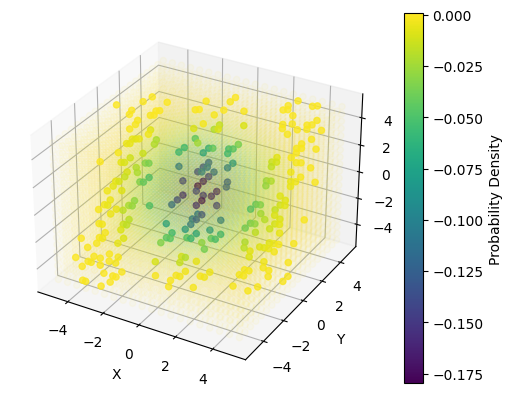

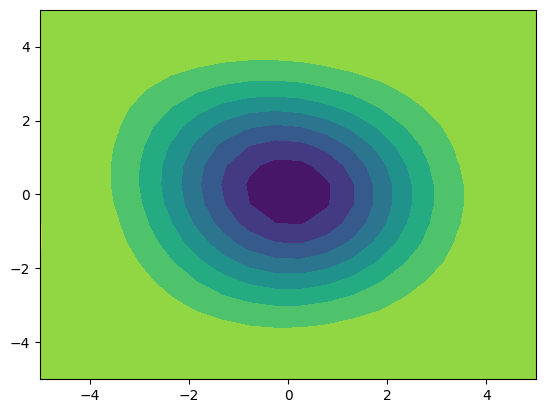

Epoch [9001/1000000], Loss: 0.007845484651625156, LDE_Loss: 0.0036, Orth_Loss: 0.0000, Norm_Loss: 0.0005, BC_Loss: 0.0037, Eigenvalue: 1.7454, Vari_E: 2.6544, Solutions: 0


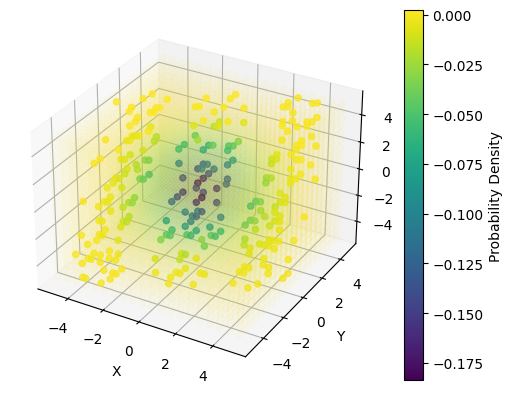

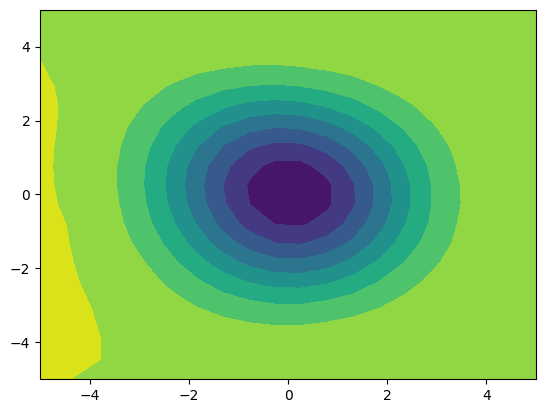

Epoch [10001/1000000], Loss: 0.011522827669978142, LDE_Loss: 0.0035, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0081, Eigenvalue: 1.8158, Vari_E: 2.6021, Solutions: 0


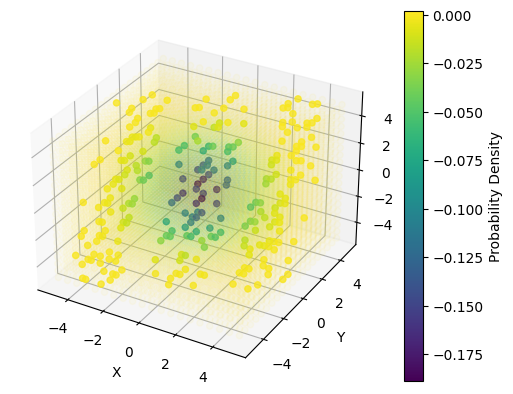

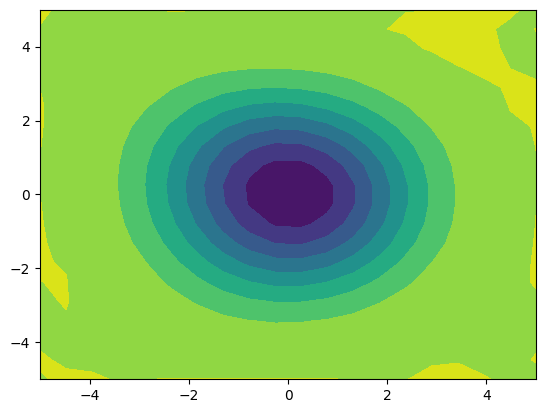

Epoch [11001/1000000], Loss: 0.003234824864193797, LDE_Loss: 0.0028, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0004, Eigenvalue: 1.8441, Vari_E: 2.5072, Solutions: 0


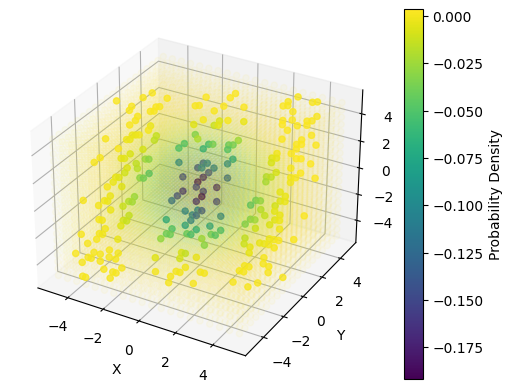

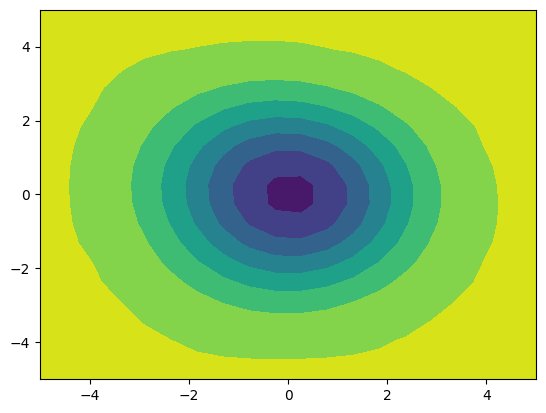

Epoch [12001/1000000], Loss: 0.01566239446401596, LDE_Loss: 0.0031, Orth_Loss: 0.0000, Norm_Loss: 0.0016, BC_Loss: 0.0110, Eigenvalue: 1.8818, Vari_E: 2.4923, Solutions: 0


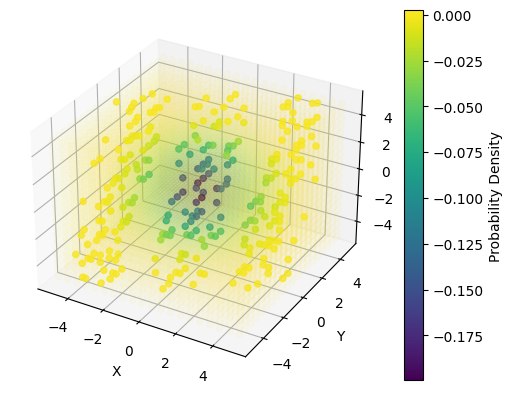

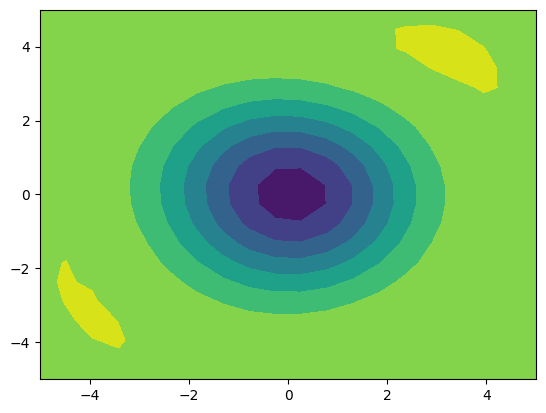

Epoch [13001/1000000], Loss: 0.0027480076532810926, LDE_Loss: 0.0021, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0006, Eigenvalue: 1.9153, Vari_E: 2.3520, Solutions: 0


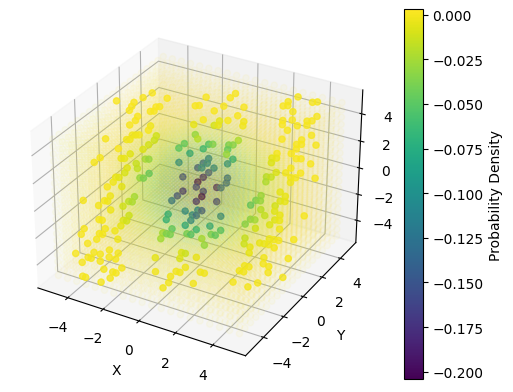

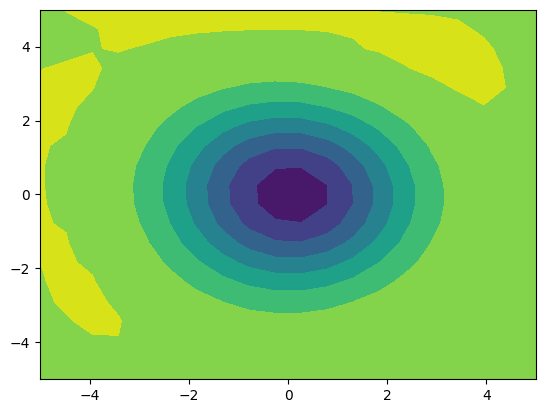

Epoch [14001/1000000], Loss: 0.004381656646728516, LDE_Loss: 0.0019, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0024, Eigenvalue: 1.9195, Vari_E: 2.2929, Solutions: 0


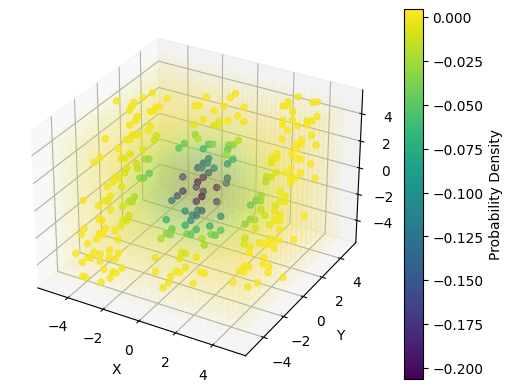

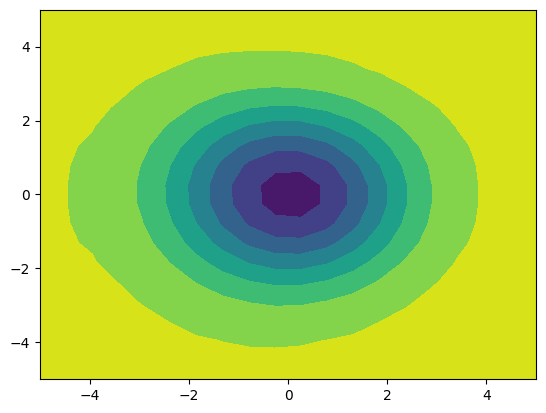

Epoch [15001/1000000], Loss: 0.019487904384732246, LDE_Loss: 0.0023, Orth_Loss: 0.0000, Norm_Loss: 0.0013, BC_Loss: 0.0159, Eigenvalue: 1.9353, Vari_E: 2.2925, Solutions: 0


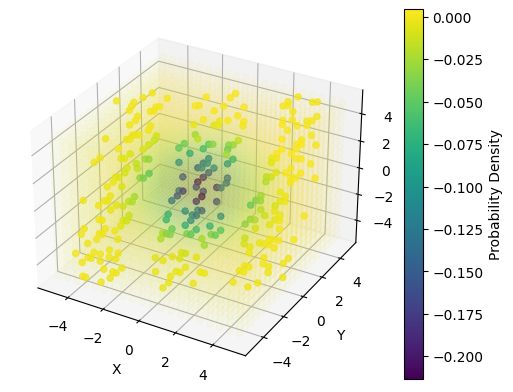

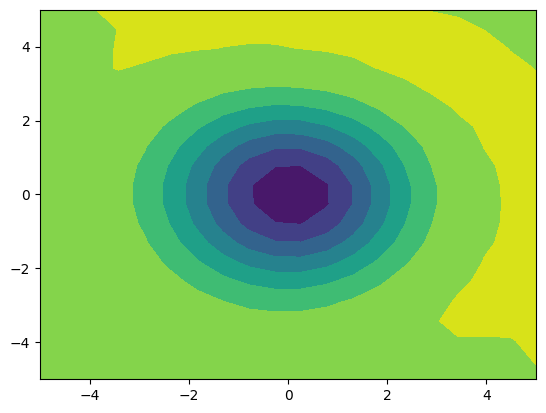

Epoch [16001/1000000], Loss: 0.010023467242717743, LDE_Loss: 0.0017, Orth_Loss: 0.0000, Norm_Loss: 0.0001, BC_Loss: 0.0082, Eigenvalue: 1.9286, Vari_E: 2.1890, Solutions: 0


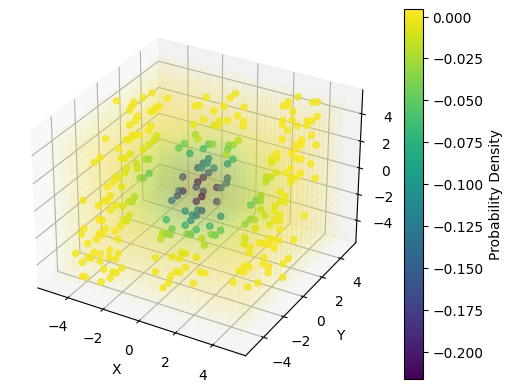

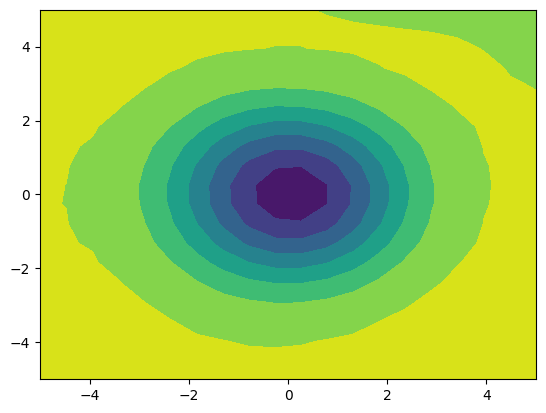

Epoch [17001/1000000], Loss: 0.008003951981663704, LDE_Loss: 0.0016, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0063, Eigenvalue: 1.9289, Vari_E: 2.1616, Solutions: 0


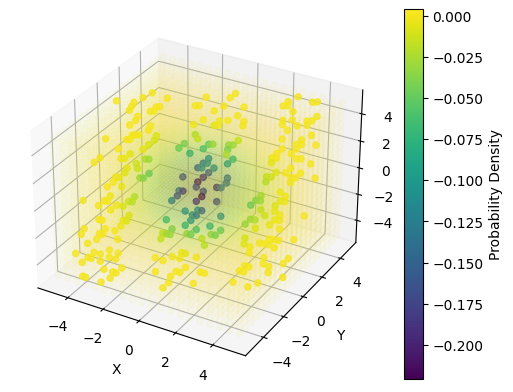

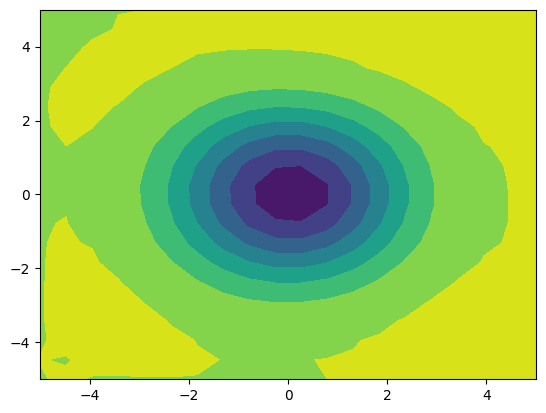

Epoch [18001/1000000], Loss: 0.001668721903115511, LDE_Loss: 0.0013, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0003, Eigenvalue: 1.9263, Vari_E: 2.1045, Solutions: 0


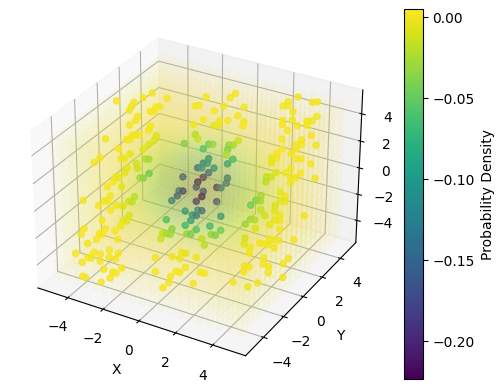

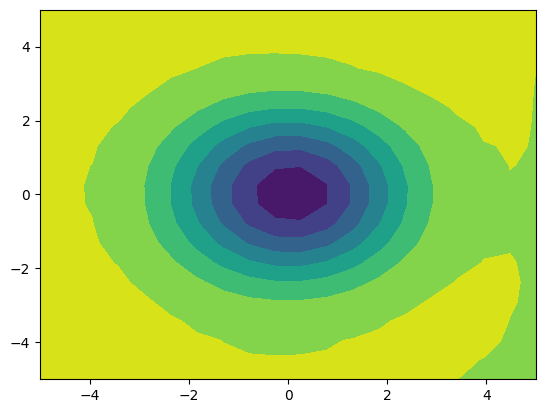

Epoch [19001/1000000], Loss: 0.002173621440306306, LDE_Loss: 0.0013, Orth_Loss: 0.0000, Norm_Loss: 0.0001, BC_Loss: 0.0008, Eigenvalue: 1.9231, Vari_E: 2.0804, Solutions: 0


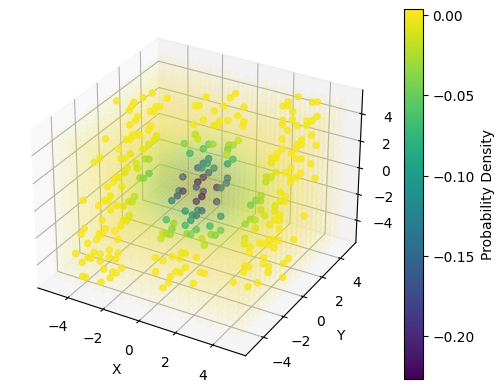

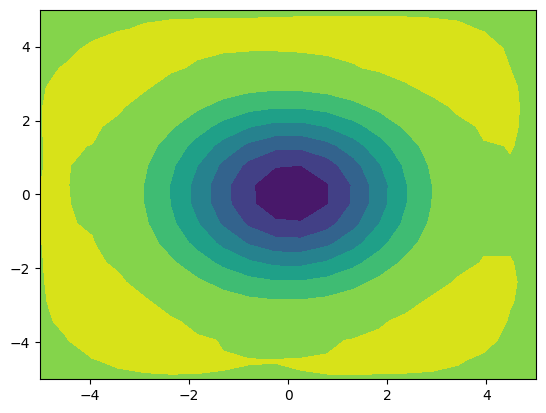

Epoch [20001/1000000], Loss: 0.0015348439337685704, LDE_Loss: 0.0012, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0003, Eigenvalue: 1.9267, Vari_E: 2.0462, Solutions: 0


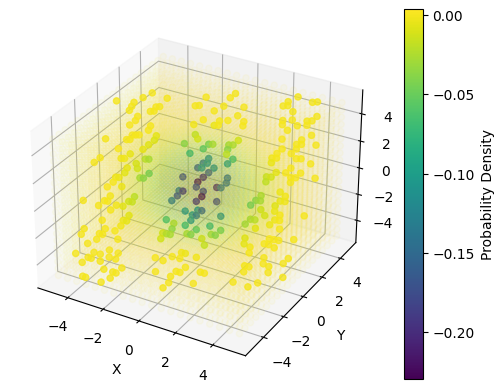

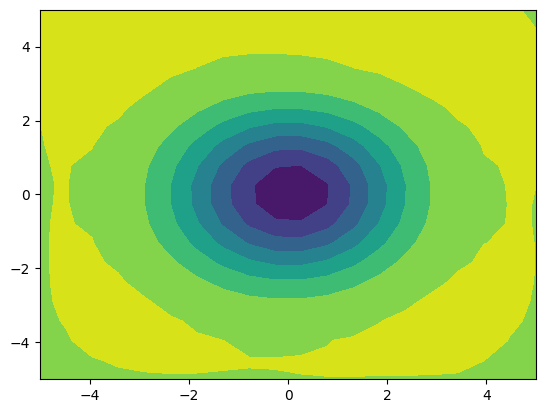

Epoch [21001/1000000], Loss: 0.0014441743260249496, LDE_Loss: 0.0012, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0003, Eigenvalue: 1.9122, Vari_E: 2.0218, Solutions: 0


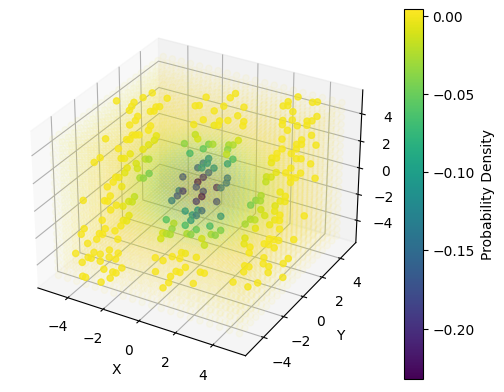

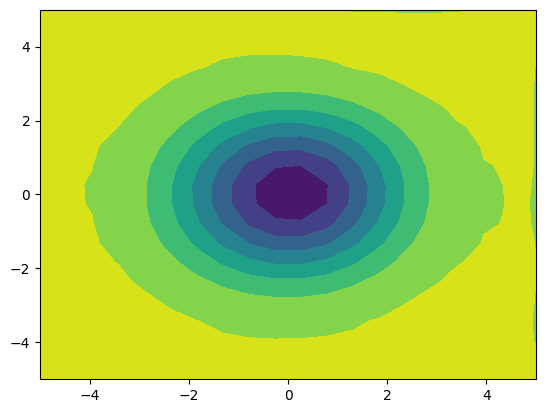

Epoch [22001/1000000], Loss: 0.0016420145984739065, LDE_Loss: 0.0011, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0005, Eigenvalue: 1.9020, Vari_E: 2.0031, Solutions: 0


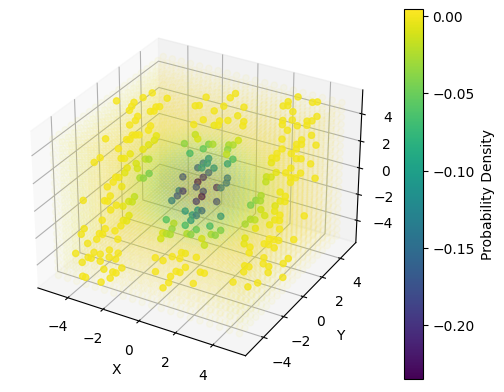

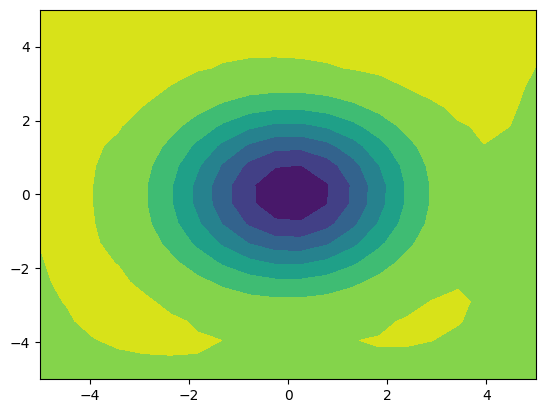

Epoch [23001/1000000], Loss: 0.004396727774292231, LDE_Loss: 0.0012, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0032, Eigenvalue: 1.8985, Vari_E: 1.9871, Solutions: 0


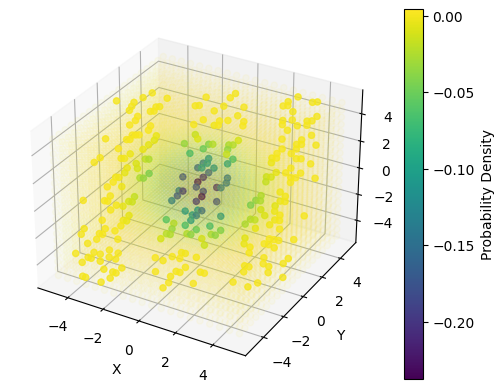

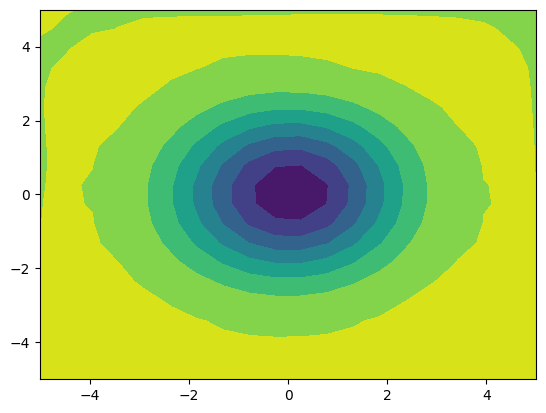

Epoch [24001/1000000], Loss: 0.001445043133571744, LDE_Loss: 0.0010, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0004, Eigenvalue: 1.8796, Vari_E: 1.9642, Solutions: 0


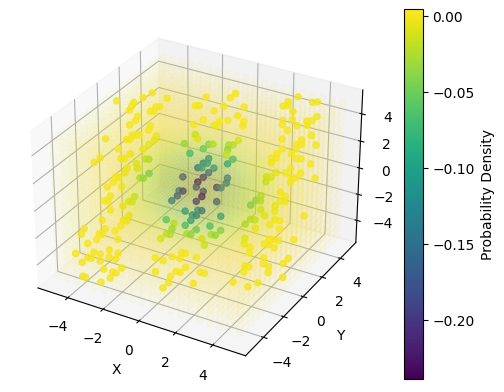

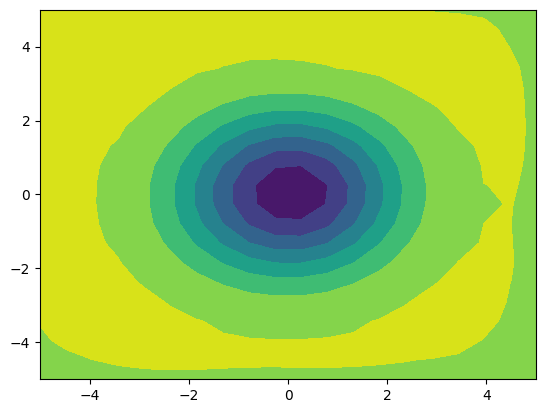

Epoch [25001/1000000], Loss: 0.0013561465311795473, LDE_Loss: 0.0010, Orth_Loss: 0.0000, Norm_Loss: 0.0000, BC_Loss: 0.0003, Eigenvalue: 1.8725, Vari_E: 1.9505, Solutions: 0


In [ ]:
model = NN(D, Nh)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

learning_rates = {'lambda_layer': 0.05, 'layer1': 0.0005, 'layer2': 0.0005, 'layer3': 0.0005, 'layer4': 0.0005}
parameters = [{'params': getattr(model, name).parameters(), 'lr': lr} for name, lr in learning_rates.items()]

optimizer = optim.Adam(parameters)

step_size = 1500
gamma = 0.95
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

loss_history, E_history, models, last_model, li = train3D(model, optimizer, scheduler, learning_rates, 1000000, num_samples, data_range)


**IGNORE BELOW, THEY ARE FOR TESTING**

tensor(5.9620, device='cuda:0', grad_fn=<MeanBackward0>) tensor(5.9701, device='cuda:0', grad_fn=<DivBackward0>)
0.4761934
-0.45351636


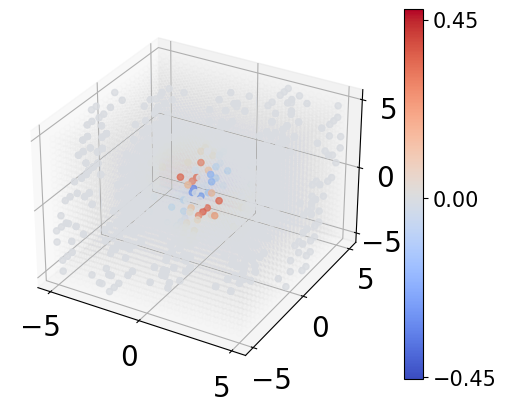

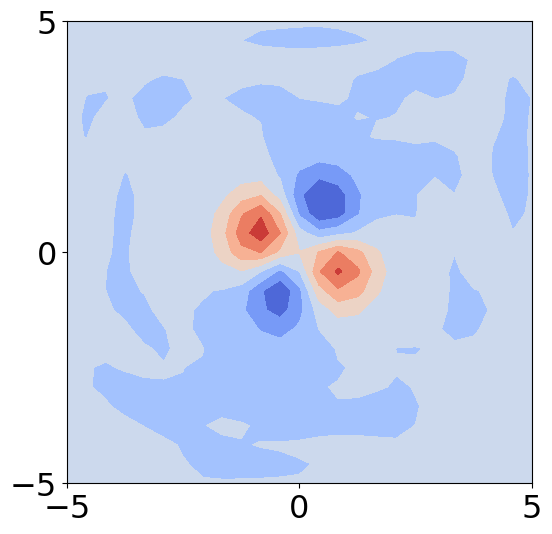

In [ ]:
num = 25
min_val = -5
max_val = 5
data1 = torch.linspace(min_val, max_val, num)
data2 = torch.linspace(min_val, max_val, num)
data3 = torch.linspace(min_val, max_val, num)
X, Y, Z = torch.meshgrid(data1, data2, data3)
data1 = X.reshape(-1, 1)
data2 = Y.reshape(-1, 1)
data3 = Z.reshape(-1, 1)
data_concat = torch.hstack((data1, data2, data3)).to(device)
data_concat.requires_grad = True

pred, E = models[3](data_concat, device)

kinematics, grads = kinematics_f(data_concat, pred)
H_psi = kinematics + Nilsson_model(data_concat, device) * pred

print(E.mean(), torch.sum(pred * H_psi) / torch.sum(pred * pred))

psi_3d = pred.detach().cpu().numpy().reshape(num, num, num)
probability_density_flat = psi_3d.flatten()
print(np.max(probability_density_flat))
print(np.min(probability_density_flat))

opacity = np.where(np.abs(probability_density_flat) < 0.05, 0.01, 0.8)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
num_ticks = 3
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='z', labelsize=20)
ticks = [min_val, 0, max_val]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks(ticks)

scatter = ax.scatter(data1, data2, data3, c=probability_density_flat, cmap='coolwarm', alpha = opacity)
cbar = fig.colorbar(scatter, ticks=[-0.45, 0, 0.45])
cbar.ax.tick_params(labelsize=15)
plt.show()



# Projection onto 2D contour plot
fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
contour = ax2.contourf(X[:, :, 0], Y[:, :, 0], psi_3d.sum(axis=2), cmap='coolwarm')
plt.yticks([-5, 0, 5], fontsize=23)
plt.xticks([-5, 0, 5], fontsize=23)

plt.show()

In [ ]:
plt.figure()
plt.plot(np.array(E_history)[:, 0])
plt.plot(np.array(E_history)[:, 1])
plt.legend(("Model Energy", "Variational Energy"))
plt.title("Energy Evolution Across Epochs For Woods-Saxon Potential")
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.show()

In [ ]:
# Specify the file name
file_name = "energyDHO.txt"
# Open the file in write mode (this will create the file if it doesn't exist)
with open(file_name, "w") as file:
    # Write the content to the file
    for i in E_history:
      file.write(str(i) + '\n')

In [ ]:
plt.figure()
plt.plot(loss_history[:])
plt.title("Total Loss Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.show()